# <center>Artificial Neural Network (ANN)</center>

In [1]:
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from tqdm import tqdm
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchmetrics
import tenseal as ts

In [3]:
# Importing the dataset and undersampling it to avoid biases
df = pd.read_csv(r"C:\Users\manig\Downloads\Mitacs\top_features.csv")
grouped = df.groupby('Label')
df = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
x = df.drop(["Label"], axis = 1)
y = df["Label"]

# Scaling
scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

#Splitting the dataset into training, testing and validation set
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.20, random_state=42)
x_val, x_test_20, y_val, y_test_20 = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
x_train=torch.from_numpy(x_train).float()
x_val=torch.from_numpy(x_val).float()
x_test_20=torch.from_numpy(x_test_20).float()
y_train=torch.from_numpy(np.array(y_train)).float().unsqueeze(1)
y_val=torch.from_numpy(np.array(y_val)).float().unsqueeze(1)
y_test_20=torch.from_numpy(np.array(y_test_20)).float().unsqueeze(1)
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test_20.shape}")
print(f"y_test shape: {y_test_20.shape}")

x_train shape: torch.Size([681185, 30])
y_train shape: torch.Size([681185, 1])
x_val shape: torch.Size([85148, 30])
y_val shape: torch.Size([85148, 1])
x_test shape: torch.Size([85149, 30])
y_test shape: torch.Size([85149, 1])


In [3]:
del x, y, grouped, df

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# ANN Model
class NN(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=n_features, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=8)
        self.layer_3 = nn.Linear(in_features=8, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = x*x
        x = self.layer_2(x)
        x = x*x
        x = self.layer_3(x)
        return x

In [6]:
# Validation function
def validate(model, criterion, x_val, y_val):
    model.eval()  
    with torch.no_grad():  
        outputs = model(x_val)
        loss = criterion(outputs, y_val)
        acc, _ = accuracy(model, x_val, y_val)
    model.train()  
    return loss.data, acc

In [7]:
def accuracy(model, x, y, train=True):
    out_list = []
#     x, y = x.to(device), y.to(device)
    t_start = time.time()
    out = torch.sigmoid(model(x))
    if(train==False):
        t_end = time.time()
        print(f"Prediction Time: {(t_end - t_start)} seconds")
    out_list.append(out)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean(), out

In [8]:
# Training function
def train(model, optimizer, criterion, scheduler, x, y, x_val, y_val, epochs):
    train_loss_dict = {}
    train_acc_dict = {}
    val_loss_dict = {}
    val_acc_dict = {}
    for e in range(1, epochs + 1):
        model.train()
        out = model(x)
        optimizer.zero_grad()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
#         scheduler.step(loss.data)
        train_loss = loss.data
        train_loss_dict[e] = train_loss
        train_acc, _ = accuracy(model, x, y)
        train_acc_dict[e] = train_acc
        val_loss, val_acc = validate(model, criterion, x_val, y_val)
        val_loss_dict[e] = val_loss
        val_acc_dict[e] = val_acc
        if e%100 == 0:
            print(f"Epoch {e} - Training loss: {train_loss}, Training accuracy: {train_acc}, Validation loss: {val_loss}, Validation accuracy: {val_acc}, Learning Rate: {optimizer.param_groups[0]['lr']}\n")
    return model, train_loss_dict, train_acc_dict, val_loss_dict, val_acc_dict

In [9]:
if device == "cuda":
    x_train, y_train, x_val, y_val = x_train.to(device), y_train.to(device), x_val.to(device), y_val.to(device)

NN(
  (layer_1): Linear(in_features=30, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)
Epoch 100 - Training loss: 0.16057245433330536, Training accuracy: 0.9356004595756531, Validation loss: 0.3637044429779053, Validation accuracy: 0.9345727562904358, Learning Rate: 0.013

Epoch 200 - Training loss: 0.12261751294136047, Training accuracy: 0.9480786919593811, Validation loss: 0.36068376898765564, Validation accuracy: 0.9472682476043701, Learning Rate: 0.013

Epoch 300 - Training loss: 0.11265402287244797, Training accuracy: 0.9545806050300598, Validation loss: 0.3068757951259613, Validation accuracy: 0.9543852806091309, Learning Rate: 0.013

Epoch 400 - Training loss: 0.11115255206823349, Training accuracy: 0.9528571367263794, Validation loss: 0.2054438441991806, Validation accuracy: 0.952823281288147, Learning Rate: 0.013

Epoch 500 - Training loss: 0.10284499078

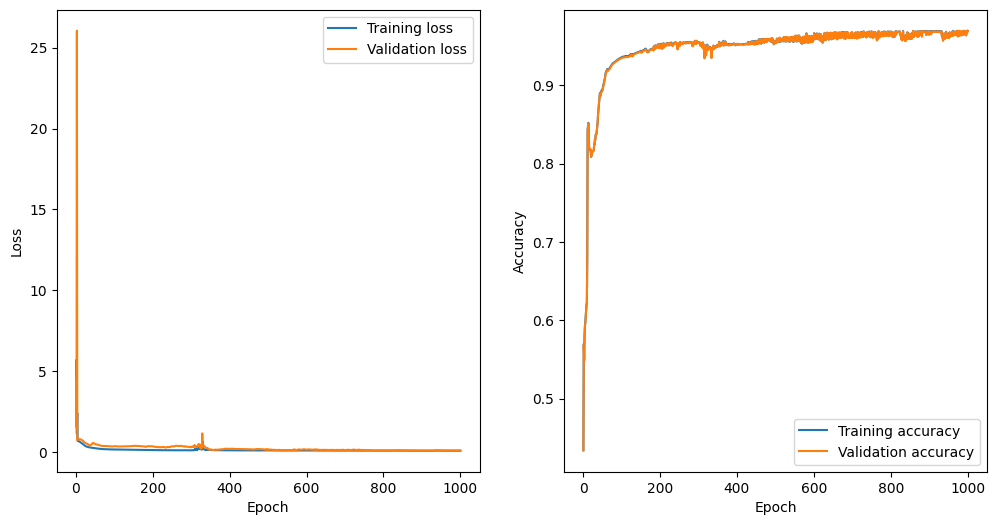

In [10]:
# Training and validating the model on unencrypted data
n_features = x_train.shape[1]
torch.manual_seed(42)
model = NN(n_features).to(device)
print(model)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(),  lr=0.013)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)

EPOCH = 1000
t_start = time.time()
model, train_loss_dict, train_acc_dict, val_loss_dict, val_acc_dict = train(model, optimizer, loss_fn, scheduler, x_train, y_train, x_val, y_val, EPOCH)
t_end = time.time()
print(f"Training Time: {int(t_end - t_start)} seconds")

if device == "cuda":
    train_loss_dict = {k: v.cpu() for k, v in train_loss_dict.items()}
    val_loss_dict = {k: v.cpu() for k, v in val_loss_dict.items()}
    train_acc_dict = {k: v.cpu() for k, v in train_acc_dict.items()}
    val_acc_dict = {k: v.cpu() for k, v in val_acc_dict.items()}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(*zip(*train_loss_dict.items()), label='Training loss')
ax1.plot(*zip(*val_loss_dict.items()), label='Validation loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(*zip(*train_acc_dict.items()), label='Training accuracy')
ax2.plot(*zip(*val_acc_dict.items()), label='Validation accuracy')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
plt.show()

From the loss and accuracy curve, we can see that the model neither overfitted nor underfitted

In [12]:
# Testing - Calculating Accuracy, Recall, Precision and F1- Score on unencrypted data
plain_accuracy, op = accuracy(model.cpu(), x_test_20, y_test_20, False)
op = op.squeeze().detach().cpu().numpy()
for i in range(len(op)):
    if op[i]<0.5:
        op[i] = 0
    else:
        op[i] = 1
y_test_temp = y_test_20.squeeze().numpy()
plain_accuracy = accuracy_score(y_test_temp, op)
plain_recall = recall_score(y_test_temp, op, average='binary')  
plain_f1 = f1_score(y_test_temp, op, average='binary')  
plain_precision = precision_score(y_test_temp, op, average='binary')  
print(f"Accuracy: {plain_accuracy}")
print(f"Recall: {plain_recall}")
print(f"Precision: {plain_precision}")
print(f"F1 - Score: {plain_f1}")

Prediction Time: 0.0049855709075927734 seconds
Accuracy: 0.9686314577975079
Recall: 0.9875070448994928
Precision: 0.9515964789210473
F1 - Score: 0.9692192451743014


In [13]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "ann_3_layers.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [14]:
model = model.cpu()

In [16]:
# Saving the model weights and biases
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH) 

Saving model to: models\ann_3_layers.pth


In [17]:
# Loading the model weights and biases
model = NN(30)
model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [32]:
# Class to define forward function for encrypted model evaluation using weights and biases
class EncryptedANN:
    
    def __init__(self, torch_ann):
        self.layer_1_weight = torch_ann.layer_1.weight.T.data.tolist()
        self.layer_1_bias = torch_ann.layer_1.bias.data.tolist()

        self.layer_2_weight = torch_ann.layer_2.weight.T.data.tolist()
        self.layer_2_bias = torch_ann.layer_2.bias.data.tolist()
        
        self.layer_3_weight = torch_ann.layer_3.weight.T.data.tolist()
        self.layer_3_bias = torch_ann.layer_3.bias.data.tolist()
        
    def forward(self, enc_x):
        enc_x = enc_x.mm(self.layer_1_weight) + self.layer_1_bias
        enc_x.square_()
        
        enc_x = enc_x.mm(self.layer_2_weight) + self.layer_2_bias
        enc_x.square_()
                
        enc_x = enc_x.mm(self.layer_3_weight) + self.layer_3_bias
        
        return enc_x
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
#     def encrypt(self, context):
#         self.layer_1_weight =  ts.ckks_vector(context, self.layer_1_weight)
#         self.layer_1_bias = ts.ckks_vector(context, self.layer_1_bias)

#         self.layer_2_weight = ts.ckks_vector(context, self.layer_2_weight)
#         self.layer_2_bias = ts.ckks_vector(context, self.layer_2_bias)
        
#         self.layer_3_weight = ts.ckks_vector(context, self.layer_3_weight)
#         self.layer_3_bias = ts.ckks_vector(context, self.layer_3_bias)
        
#     def decrypt(self, context):
#         self.layer_1_weight =  self.layer_1_weight.decrypt()
#         self.layer_1_bias = self.layer_1_bias.decrypt()

#         self.layer_2_weight = self.layer_2_weight.decrypt()
#         self.layer_2_bias = self.layer_2_bias.decrypt()
        
#         self.layer_3_weight = self.layer_3_weight.decrypt()
#         self.layer_3_bias = self.layer_3_bias.decrypt()
        
eelr = EncryptedANN(model)

In [20]:
# Defining TenSEAL Context
poly_mod_degree = 16384
bits_scale = 40
integer_scale = 60
coeff_mod_bit_sizes = [integer_scale, bits_scale, bits_scale, bits_scale, bits_scale, integer_scale]
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_eval.global_scale = 2 ** bits_scale
ctx_eval.generate_galois_keys()

In [21]:
# This function evaluates on encrypted data and applies sigmoid operation after decryption
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time.time()
    output_list = []
    correct = 0
    for enc_x, y in zip(enc_x_test, y_test):
        enc_out = model(enc_x)
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        if torch.abs(out - y) < 0.5:
            correct += 1
        output_list.append(out)
    t_end = time.time()
    print(f"Evaluated test set of {len(enc_x_test)} entries in {int(t_end - t_start)} seconds")
    print(f"Score: {correct}/{len(enc_x_test)}")
    return correct / len(enc_x_test), output_list

In [10]:
# Splitting the test set into 20 parts and testing them individually 
# (did this because testing 1/20th of testing set id faster than testing the whole set at one so it helps to check accuracy and tell whether the parameters selected are good or bad upto some extent)
one_part = y_test_20.shape[0] // 20
for i in range(1, 21):
    if i==1:
        j = one_part
        temp_x_test = x_test_20[:j,]
        temp_y_test = y_test_20[:j,]
    elif i==20:
        j = one_part * (i-1)
        temp_x_test = x_test_20[j:,]
        temp_y_test = y_test_20[j:,]
    else:
        j = one_part * i
        if i == 1:
            k = one_part
        else:
            k = one_part * (i-1)
        temp_x_test = x_test_20[k:j,]
        temp_y_test = y_test_20[k:j,]
    
    t_start = time.time()
    enc_x_test = []
    print(f"Starting Batch {i} Encryption")
    for x in tqdm(range(len(temp_x_test))):
        enc_x_test.append(ts.ckks_vector(ctx_eval, temp_x_test[x].tolist()))
    t_end = time.time()
    print(f"Encryption of the test set took {int(t_end - t_start)} seconds")
    encrypted_accuracy, output_list = encrypted_evaluation(eelr, enc_x_test, temp_y_test)
    print(f"Batch {i} Encrypted Accuracy: {encrypted_accuracy}")
    y_pred = torch.cat(output_list)
    y_pred = y_pred.numpy()
    y_pred_final.extend(y_pred)

Starting Batch 1 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:04<00:00, 65.85it/s]


Encryption of the test set took 64 seconds
Evaluated test set of 4257 entries in 1696 seconds
Score: 4037/4257
Batch 1 Encrypted Accuracy: 0.9483204134366925
Starting Batch 2 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:07<00:00, 62.78it/s]


Encryption of the test set took 67 seconds
Evaluated test set of 4257 entries in 1687 seconds
Score: 4062/4257
Batch 2 Encrypted Accuracy: 0.9541930937279774
Starting Batch 3 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:08<00:00, 62.15it/s]


Encryption of the test set took 68 seconds
Evaluated test set of 4257 entries in 1802 seconds
Score: 4033/4257
Batch 3 Encrypted Accuracy: 0.9473807845900869
Starting Batch 4 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:07<00:00, 62.79it/s]


Encryption of the test set took 67 seconds
Evaluated test set of 4257 entries in 1759 seconds
Score: 4018/4257
Batch 4 Encrypted Accuracy: 0.943857176415316
Starting Batch 5 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:04<00:00, 65.61it/s]


Encryption of the test set took 64 seconds
Evaluated test set of 4257 entries in 1659 seconds
Score: 4058/4257
Batch 5 Encrypted Accuracy: 0.9532534648813719
Starting Batch 6 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:05<00:00, 64.92it/s]


Encryption of the test set took 65 seconds
Evaluated test set of 4257 entries in 1662 seconds
Score: 4042/4257
Batch 6 Encrypted Accuracy: 0.9494949494949495
Starting Batch 7 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:04<00:00, 65.64it/s]


Encryption of the test set took 64 seconds
Evaluated test set of 4257 entries in 1656 seconds
Score: 4030/4257
Batch 7 Encrypted Accuracy: 0.9466760629551327
Starting Batch 8 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:04<00:00, 66.18it/s]


Encryption of the test set took 64 seconds
Evaluated test set of 4257 entries in 1655 seconds
Score: 4002/4257
Batch 8 Encrypted Accuracy: 0.9400986610288936
Starting Batch 9 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:04<00:00, 66.25it/s]


Encryption of the test set took 64 seconds
Evaluated test set of 4257 entries in 1651 seconds
Score: 4023/4257
Batch 9 Encrypted Accuracy: 0.945031712473573
Starting Batch 10 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:04<00:00, 66.32it/s]


Encryption of the test set took 64 seconds
Evaluated test set of 4257 entries in 1650 seconds
Score: 4025/4257
Batch 10 Encrypted Accuracy: 0.9455015268968757
Starting Batch 11 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:04<00:00, 66.51it/s]


Encryption of the test set took 64 seconds
Evaluated test set of 4257 entries in 1646 seconds
Score: 4031/4257
Batch 11 Encrypted Accuracy: 0.9469109701667842
Starting Batch 12 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:04<00:00, 66.09it/s]


Encryption of the test set took 64 seconds
Evaluated test set of 4257 entries in 1647 seconds
Score: 4054/4257
Batch 12 Encrypted Accuracy: 0.9523138360347663
Starting Batch 13 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:03<00:00, 66.52it/s]


Encryption of the test set took 63 seconds
Evaluated test set of 4257 entries in 1645 seconds
Score: 4020/4257
Batch 13 Encrypted Accuracy: 0.9443269908386187
Starting Batch 14 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:03<00:00, 66.68it/s]


Encryption of the test set took 63 seconds
Evaluated test set of 4257 entries in 1644 seconds
Score: 4046/4257
Batch 14 Encrypted Accuracy: 0.9504345783415551
Starting Batch 15 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:04<00:00, 66.05it/s]


Encryption of the test set took 64 seconds
Evaluated test set of 4257 entries in 1641 seconds
Score: 4033/4257
Batch 15 Encrypted Accuracy: 0.9473807845900869
Starting Batch 16 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:04<00:00, 66.35it/s]


Encryption of the test set took 64 seconds
Evaluated test set of 4257 entries in 1640 seconds
Score: 4053/4257
Batch 16 Encrypted Accuracy: 0.9520789288231148
Starting Batch 17 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:03<00:00, 66.72it/s]


Encryption of the test set took 63 seconds
Evaluated test set of 4257 entries in 1639 seconds
Score: 4045/4257
Batch 17 Encrypted Accuracy: 0.9501996711299037
Starting Batch 18 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:03<00:00, 66.77it/s]


Encryption of the test set took 63 seconds
Evaluated test set of 4257 entries in 1636 seconds
Score: 4013/4257
Batch 18 Encrypted Accuracy: 0.942682640357059
Starting Batch 19 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4257/4257 [01:03<00:00, 66.73it/s]


Encryption of the test set took 63 seconds
Evaluated test set of 4257 entries in 1636 seconds
Score: 4028/4257
Batch 19 Encrypted Accuracy: 0.9462062485318299
Starting Batch 20 Encryption


100%|██████████████████████████████████████████████████████████████████████████████| 4266/4266 [01:03<00:00, 66.91it/s]


Encryption of the test set took 63 seconds
Evaluated test set of 4266 entries in 1642 seconds
Score: 4001/4266
Batch 20 Encrypted Accuracy: 0.9378809188935772


In [13]:
# Testing - Calculating Accuracy, Recall, Precision and F1- Score on encrypted data
y_pred_final_temp = y_pred_final
for i in range(len(y_pred_final)):
    if y_pred_final[i]<0.5:
        y_pred_final[i] = 0
    else:
        y_pred_final[i] = 1
y_test_temp = y_test_20.squeeze().numpy()
enc_accuracy = accuracy_score(y_test_temp, y_pred_final)
enc_recall = recall_score(y_test_temp, y_pred_final, average='binary')
enc_f1 = f1_score(y_test_temp, y_pred_final, average='binary')
enc_precision = precision_score(y_test_temp, y_pred_final, average='binary')
print(f"Accuracy: {enc_accuracy}")
print(f"Recall: {enc_recall}")
print(f"Precision: {enc_precision}")
print(f"F1 - Score: {enc_f1}")

Accuracy: 0.9472101845001115
Recall: 0.9839845951531091
Precision: 0.9165919282511211
F1 - Score: 0.9490934212165483


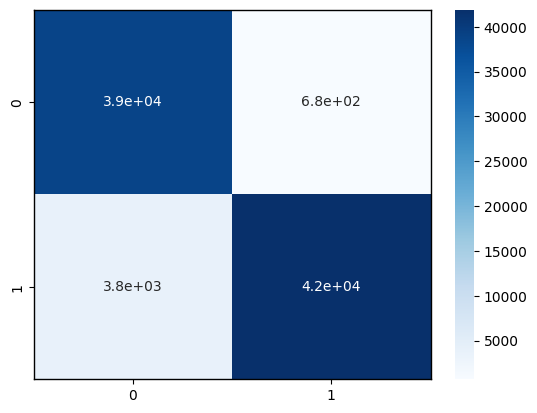

In [26]:
# Confusion Matrix
confmat = torchmetrics.ConfusionMatrix(task="binary", num_classes=2)
cnf_matrix_val = confmat(y_test_20, torch.tensor(y_pred_final).float().unsqueeze(1))
cnf_matrix = sns.heatmap(cnf_matrix_val.numpy(), annot=True, cmap='Blues')
for _, spine in cnf_matrix.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
plt.show()

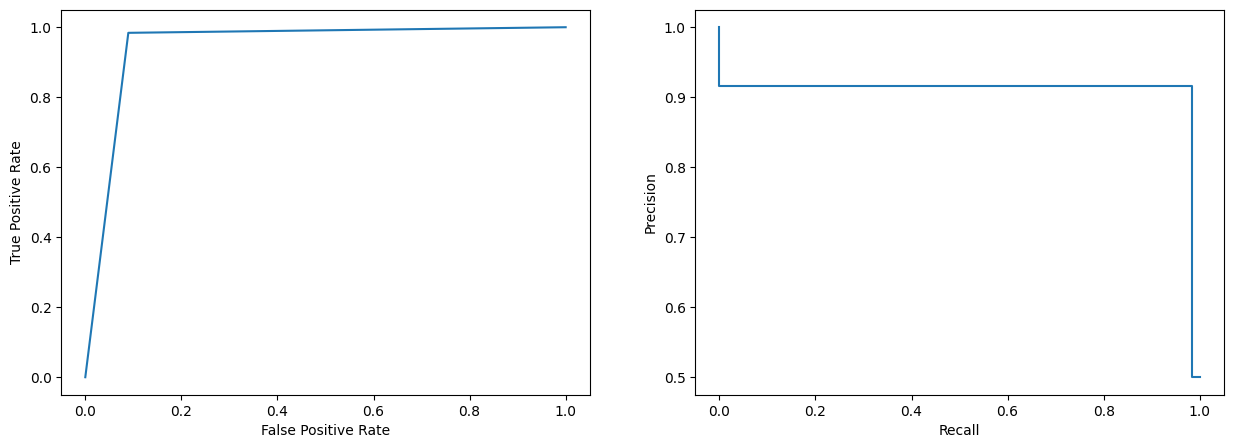

In [33]:
# ROC Curve and Precision-Recall curve
fpr, tpr, _ = roc_curve(y_test_20, torch.tensor(y_pred_final).float().unsqueeze(1).numpy())
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
prec, recall, _ = precision_recall_curve(y_test_20, torch.tensor(y_pred_final).float().unsqueeze(1).numpy())
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()